In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import os
import random
import shutil
from shutil import copy
from collections import defaultdict
import tensorflow as tf
import keras.backend as K
from patchify import patchify, unpatchify
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

---
### Training model to predict roots


In [2]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [3]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor,mask_type):

    for image_path in glob.glob(f'Images for model/{mask_type}/{dataset_type}_images/{dataset_type}/*.png'):
        mask_suffix = f'_{mask_type}_mask.tif'
        path = f'Images for model/{mask_type}'
        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor != 1:
            image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        image_patch_path = image_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            image_patch_path_numbered = f'{image_patch_path[:-4]}_{i}.png'
            cv2.imwrite(image_patch_path_numbered, patch)

        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)
        mask = cv2.imread(mask_path, 0)
        mask = padder(mask, patch_size)
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(mask, (patch_size, patch_size), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        mask_patch_path = mask_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            mask_patch_path_numbered = f'{mask_patch_path[:-4]}_{i}.png'
            cv2.imwrite(mask_patch_path_numbered, patch)

In [4]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5,y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, lr):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(lr=lr) 
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

In [6]:
patch_size = 128
scaling_factor = 1

In [7]:
mask_type = 'root'

In [8]:
patch_dir = 'Images for model/root_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val','test_images/test','test_masks/test']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [9]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)

In [10]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)


Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [11]:
model_root = simple_unet_model(patch_size, patch_size, 1, lr=0.001)

from keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor='val_iou',
                   patience=7   ,
                   restore_best_weights='True',
                   mode='max')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
h_root = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16
    ,callbacks=[cb]
)

Epoch 1/50
1980/1980 [==============================] - 124s 59ms/step - loss: 0.0342 - accuracy: 0.9933 - f1: 0.0400 - iou: 0.8181 - val_loss: 0.0095 - val_accuracy: 0.9972 - val_f1: 0.2551 - val_iou: 0.8009
Epoch 2/50
1980/1980 [==============================] - 118s 60ms/step - loss: 0.0135 - accuracy: 0.9961 - f1: 0.4574 - iou: 0.8289 - val_loss: 0.0052 - val_accuracy: 0.9985 - val_f1: 0.3817 - val_iou: 0.8894
Epoch 3/50
1980/1980 [==============================] - 119s 60ms/step - loss: 0.0102 - accuracy: 0.9967 - f1: 0.5239 - iou: 0.8626 - val_loss: 0.0055 - val_accuracy: 0.9986 - val_f1: 0.3990 - val_iou: 0.8920
Epoch 4/50
1980/1980 [==============================] - 119s 60ms/step - loss: 0.0082 - accuracy: 0.9971 - f1: 0.5864 - iou: 0.8933 - val_loss: 0.0033 - val_accuracy: 0.9988 - val_f1: 0.4635 - val_iou: 0.9353
Epoch 5/50
1980/1980 [==============================] - 119s 60ms/step - loss: 0.0071 - accuracy: 0.9974 - f1: 0.6040 - iou: 0.9100 - val_loss: 0.0042 - val_accurac

Preparation of plant images

In [13]:
input_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images'
output_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images_mask'

os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    image = padder(image, patch_size)
    
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
    
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model_root.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
    
    # Cropping the predicted mask
    crop_top, crop_bottom, crop_left, crop_right = 33, 33, 11, 11
    predicted_mask = predicted_mask[crop_top:-crop_bottom, crop_left:-crop_right]
    
    # Apply thresholding to the predicted mask if needed
    # threshold = 0.5  
    # predicted_mask = (predicted_mask > threshold).astype(np.uint8)
    
    output_filename = image_file.replace('.tif', '_root_mask_predicted.png')
    output_file = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_file, predicted_mask * 255)

25/25 [==============================] - 1s 30ms/step


In [39]:
def visualize_detected_instances(mask_path):
    combined_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    cv2.line(combined_mask, (1377, 0), (1350, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (1895, 0), (2000, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2515, 0), (2500, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2920, 0), (3000, combined_mask.shape[0]), (0, 0, 0), thickness=5)

    combined_mask = cv2.medianBlur(combined_mask, 7)
    _, thresholded = cv2.threshold(combined_mask, 2, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 3900]

    # contours_to_use = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:len(filtered_contours)]
    contours_to_use = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[0])

    instance_id = 0
    for contour in contours_to_use:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.putText(combined_mask, str(instance_id), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.rectangle(combined_mask, (x, y), (x + w, y + h), (255, 255, 255), 3)  
        instance_id += 1


    plt.imshow(combined_mask, cmap='gray')
    plt.show()



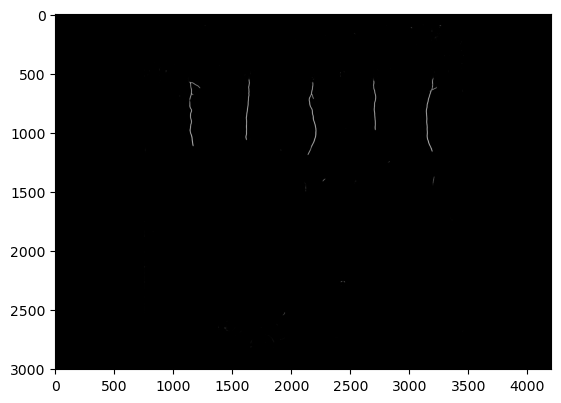

In [35]:
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images_mask\test_image_1_root_mask_predicted.png"
mask = cv2.imread(mask_path, 0)

plt.imshow(mask, cmap='gray')

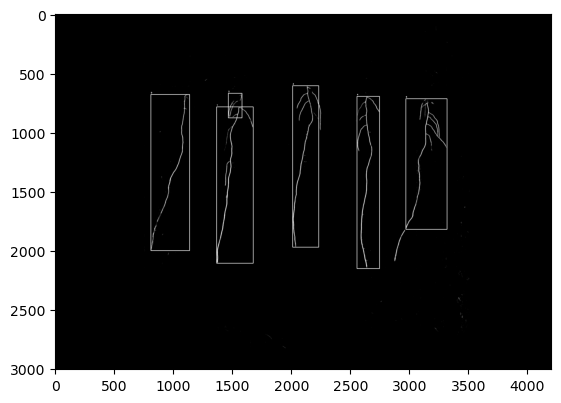

In [40]:
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images_mask\test_image_3_root_mask_predicted.png"
visualize_detected_instances(mask_path)

In [20]:
def save_detected_instances_with_crop(original_image_path, mask_path, save_path):
    original_image = cv2.imread(original_image_path)
    combined_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    cv2.line(combined_mask, (1377, 0), (1350, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (1895, 0), (2000, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2515, 0), (2500, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2920, 0), (3000, combined_mask.shape[0]), (0, 0, 0), thickness=5)

    _, thresholded = cv2.threshold(combined_mask, 2, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 3800]

    # Sort contours by their x-coordinate
    contours_to_use = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[0])

    # Ensure at least five contours are present or generate defaults
    contours_to_use.extend([None] * (5 - len(contours_to_use)))


    for instance_id, contour in enumerate(contours_to_use[:5]):
        if contour is not None:
            x, y, w, h = cv2.boundingRect(contour)
            instance_crop = original_image[y:y + h, x:x + w]

            instance_img_filename = f"instance_{instance_id}.png"
            instance_img_save_path = os.path.join(save_path, instance_img_filename)
            cv2.imwrite(instance_img_save_path, instance_crop)

            instance_mask_filename = f"instance_{instance_id}_mask.png"
            instance_mask_save_path = os.path.join(save_path, instance_mask_filename)
            cv2.imwrite(instance_mask_save_path, combined_mask[y:y + h, x:x + w])

            
        else:# Crop specific regions for each instance
             crops = [(1009, 1227, 400, 1300),
                      (1557, 1785, 400, 2000),#(1527, 1745, 400, 1100)
                      (2045, 2265, 400, 1300),
                      (2565, 2770, 400, 2000),
                      (3070, 3298, 400, 2000)]
             
             for instance_id, (start_x, end_x, top_y, bottom_y) in enumerate(crops):
                  instance_crop = original_image[top_y:bottom_y, start_x:end_x]
                  
                  instance_img_filename = f"instance_{instance_id}.png"
                  instance_img_save_path = os.path.join(save_path, instance_img_filename)
                  cv2.imwrite(instance_img_save_path, instance_crop)
                  
                  instance_mask_filename = f"instance_{instance_id}_mask.png"
                  instance_mask_save_path = os.path.join(save_path, instance_mask_filename)
                  cv2.imwrite(instance_mask_save_path, combined_mask[top_y:bottom_y, start_x:end_x])

In [21]:
save_detected_instances_with_crop(r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images\test_image_11.tif", r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images_mask\test_image_11_root_mask_predicted.png", r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\test" )

In [22]:
import os

def process_images_in_folder(input_folder, mask_folder, output_folder):
    # Iterate through files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            # Create the full file paths
            original_image_path = os.path.join(input_folder, filename)
            mask_filename = f"{os.path.splitext(filename)[0]}_root_mask_predicted.png"
            mask_path = os.path.join(mask_folder, mask_filename)
            
            # Create output folder for each image
            image_output_folder = os.path.join(output_folder, f"separated_plants_{os.path.splitext(filename)[0][-1]}")
            os.makedirs(image_output_folder, exist_ok=True)
            
            # Process each image and mask
            save_detected_instances_with_crop(original_image_path, mask_path, image_output_folder)


In [23]:
import os

def process_images_in_folder(input_folder, mask_folder, output_folder):
    # Iterate through files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            # Create the full file paths
            original_image_path = os.path.join(input_folder, filename)
            mask_filename = f"{os.path.splitext(filename)[0]}_root_mask_predicted.png"
            mask_path = os.path.join(mask_folder, mask_filename)
            
            # Extract the index from the filename
            file_index = filename.split("_")[-1].split(".")[0]
            
            # Create output folder for each image
            image_output_folder = os.path.join(output_folder, f"separated_plants_{file_index}")
            os.makedirs(image_output_folder, exist_ok=True)
            
            # Process each image and mask
            save_detected_instances_with_crop(original_image_path, mask_path, image_output_folder)


In [24]:
input_images_folder = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images"
mask_images_folder = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\images_mask"
output_images_folder = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task8\plants"

process_images_in_folder(input_images_folder, mask_images_folder, output_images_folder)


---
### task 8



In [25]:
from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects
import networkx as nx

from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
from skan import draw

### final funcion

In [26]:
import cv2
import numpy as np
import networkx as nx
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

def process_and_measure(image_path):
    # Read the image
    root_img = cv2.imread(image_path, 0)
    root_img = cv2.medianBlur(root_img, 7)

    # Skeletonize and clean the skeleton
    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=100, connectivity=2)

    # Find the largest connected component
    labels = label(cleaned_skeleton)
    regions = regionprops(labels)
    largest_component = max(regions, key=lambda x: x.area)
    largest_mask = np.zeros_like(root_img)
    largest_mask[labels == largest_component.label] = 255

    # Continue with measuring root length on the largest mask
    simple_skeleton_branch_data = summarize(Skeleton(largest_mask))

    # Measure root distances
    first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
    last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

    G = nx.from_pandas_edgelist(
        simple_skeleton_branch_data,
        'node-id-src',
        'node-id-dst',
        ['branch-distance']
    )

    path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
    print(f"Primary root length: {path_len}")

image_path = 'plants/separated_plants_3/instance_0_mask.png'
process_and_measure(image_path)


Primary root length: 1201.0092347159912


In [43]:
def process_and_measure(image_path):
    # Read the image
    root_img = cv2.imread(image_path, 0)
    root_img = cv2.medianBlur(root_img, 7)

    # Skeletonize and clean the skeleton
    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=66, connectivity=2)

    # Find the largest connected component
    labels = label(cleaned_skeleton)
    regions = regionprops(labels)

    # Check if there are regions found
    if len(regions) > 0:
        largest_component = max(regions, key=lambda x: x.area)
        largest_mask = np.zeros_like(root_img)
        largest_mask[labels == largest_component.label] = 255

        # Continue with measuring root length on the largest mask
        simple_skeleton_branch_data = summarize(Skeleton(largest_mask))

        
        # Measure root distances
        first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
        last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

        G = nx.from_pandas_edgelist(
            simple_skeleton_branch_data,
            'node-id-src',
            'node-id-dst',
            ['branch-distance']
        )

        path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
        return path_len
    else:
        # No significant structure found, set length to 0
        return 0


# Process and measure lengths for each plant instance
data = []
plant_counter = 1
for folder_index in range(1, 12):
    folder_path = f"plants\separated_plants_{folder_index}"
    for instance_index in range(5):
        image_path = os.path.join(folder_path, f"instance_{instance_index}_mask.png")
        length = process_and_measure(image_path)
        if length is not None:
            data.append({'Plant': f"Plant {plant_counter}", 'Length': length})
            plant_counter += 1
        else:
            print(f"Skipping instance: {image_path} due to error.")

# Save lengths in a table
length_table_predicted = pd.DataFrame(data)
print(length_table_predicted)

       Plant       Length
0    Plant 1   624.320851
1    Plant 2   569.852814
2    Plant 3   237.195959
3    Plant 4   509.024387
4    Plant 5   733.918831
5    Plant 6  1141.712770
6    Plant 7  1265.310750
7    Plant 8  1266.617316
8    Plant 9  1293.972655
9   Plant 10   977.362482
10  Plant 11  1201.009235
11  Plant 12  1354.298557
12  Plant 13  1467.997041
13  Plant 14  1499.470129
14  Plant 15  1127.156421
15  Plant 16  1008.931024
16  Plant 17  1016.617316
17  Plant 18   143.568542
18  Plant 19   829.132034
19  Plant 20   982.203102
20  Plant 21  1437.825469
21  Plant 22   333.007143
22  Plant 23  1142.156421
23  Plant 24  1404.813275
24  Plant 25  1528.126984
25  Plant 26     0.000000
26  Plant 27     0.000000
27  Plant 28     0.000000
28  Plant 29     0.000000
29  Plant 30     0.000000
30  Plant 31   108.083261
31  Plant 32   171.740115
32  Plant 33     0.000000
33  Plant 34   168.911688
34  Plant 35    66.970563
35  Plant 36   336.610173
36  Plant 37   327.740115
37  Plant 38

In [49]:
def process_and_measure(image_path):
    # Read the image
    root_img = cv2.imread(image_path, 0)
    # root_img = cv2.medianBlur(root_img, 7)

    # Skeletonize and clean the skeleton
    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=66, connectivity=2)

    # Find the largest connected component
    labels = label(cleaned_skeleton)
    regions = regionprops(labels)

    # Check if there are regions found
    if len(regions) > 0:
        largest_component = max(regions, key=lambda x: x.area)
        largest_mask = np.zeros_like(root_img)
        largest_mask[labels == largest_component.label] = 255

        # Continue with measuring root length on the largest mask
        simple_skeleton_branch_data = summarize(Skeleton(largest_mask))

        # Measure root distances
        first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']

        # Check if there are at least two nodes
        if len(simple_skeleton_branch_data) >= 2:
            last_node_1 = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']
            last_node_2 = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 2, 'node-id-dst']

            # Compare the lengths of last_node_1 and last_node_2
            if simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'branch-distance'] < simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 2, 'branch-distance']:
                last_node = last_node_2
            else:
                last_node = last_node_1

            G = nx.from_pandas_edgelist(
                simple_skeleton_branch_data,
                'node-id-src',
                'node-id-dst',
                ['branch-distance']
            )

            path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
            return path_len
        else:
            first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
        last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

        G = nx.from_pandas_edgelist(
            simple_skeleton_branch_data,
            'node-id-src',
            'node-id-dst',
            ['branch-distance']
        )

        path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
        return path_len
    else:
        # No significant structure found, set length to 0
        return 0


# Process and measure lengths for each plant instance
data = []
plant_counter = 1
for folder_index in range(1, 12):
    folder_path = f"plants\separated_plants_{folder_index}"
    for instance_index in range(5):
        image_path = os.path.join(folder_path, f"instance_{instance_index}_mask.png")
        length = process_and_measure(image_path)
        if length is not None:
            data.append({'Plant': f"Plant {plant_counter}", 'Length': length})
            plant_counter += 1
        else:
            print(f"Skipping instance: {image_path} due to error.")

# Save lengths in a table
length_table_predicted = pd.DataFrame(data)
print(length_table_predicted)

       Plant       Length
0    Plant 1   647.977705
1    Plant 2   579.438600
2    Plant 3   776.386868
3    Plant 4   507.024387
4    Plant 5   749.333044
5    Plant 6  1162.967604
6    Plant 7  1520.163564
7    Plant 8  1265.960461
8    Plant 9  1292.244733
9   Plant 10  1118.274170
10  Plant 11  1221.210245
11  Plant 12  1359.742207
12  Plant 13  1468.854906
13  Plant 14  1546.570635
14  Plant 15  1258.411255
15  Plant 16  1011.274170
16  Plant 17  1069.031529
17  Plant 18   955.132034
18  Plant 19   831.475180
19  Plant 20   982.717821
20  Plant 21  1457.097546
21  Plant 22  1180.776695
22  Plant 23  1165.570635
23  Plant 24  1409.085353
24  Plant 25  1530.570635
25  Plant 26     0.000000
26  Plant 27     0.000000
27  Plant 28     0.000000
28  Plant 29     0.000000
29  Plant 30     0.000000
30  Plant 31    76.112698
31  Plant 32   185.325902
32  Plant 33    22.071068
33  Plant 34   175.083261
34  Plant 35    72.213203
35  Plant 36   343.367532
36  Plant 37   344.568542
37  Plant 38

In [51]:
# Process and measure lengths for each plant instance
data = []
plant_counter = 1
for folder_index in range(1, 12):
    folder_path = f"plants\separated_plants_{folder_index}"
    for instance_index in range(5):
        image_path = os.path.join(folder_path, f"instance_{instance_index}_mask.png")
        length = process_and_measure(image_path)
        if length is not None:
            plant_id = f"test_image_{folder_index}_plant_{instance_index + 1}"
            data.append({'Plant ID': plant_id, 'Length (px)': length})
        else:
            print(f"Skipping instance: {image_path} due to error.")

# Save lengths in a CSV file
length_table_predicted = pd.DataFrame(data)
length_table_predicted.to_csv('plant_lengths.csv', index=False)
